In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from pprint import pprint

In [19]:
LABEL_INT_DICT = np.unique(pd.read_csv('ucf11_train_vid.csv')['label'])

In [20]:
LABEL_INT_DICT

array(['biking', 'diving', 'golf', 'juggle', 'jumping', 'riding',
       'shooting', 'spiking', 'swing', 'tennis', 'walk'], dtype=object)

In [21]:
LABEL_STR_DICT = { k:v  for v, k in enumerate(LABEL_INT_DICT)}
pprint(LABEL_STR_DICT)

{'biking': 0,
 'diving': 1,
 'golf': 2,
 'juggle': 3,
 'jumping': 4,
 'riding': 5,
 'shooting': 6,
 'spiking': 7,
 'swing': 8,
 'tennis': 9,
 'walk': 10}


In [22]:
import albumentations as A
import tensorflow as tf
from tensorflow import keras
import math

In [23]:
class DataGenerator(keras.utils.Sequence) :
    def __init__(self, batch_size, image_size, mode='train', shuffle=True) :
        self.mode = mode
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.image_size = image_size
        
        if self.mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    rotate_limit=15
                )
            ])
            
        self.img_paths = glob(f'UCF11_updated_png/{mode}/*.png')
        
    def __len__(self) :
        return math.ceil(len(self.img_paths) / self.batch_size)
    
    def __getitem__(self, idx) :
        start = idx * self.batch_size
        end = (idx+1) * self.batch_size
        data = self.img_paths[start:end]
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for img_path in data:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                augmented = self.transform(image=img)
                img = augmented['image']
            
            img = img.astype('float32')
            img = img / 255.
            
            label = img_path.split('/')[-1].split('_')[0]
            label = LABEL_STR_DICT[label]
            
            batch_x.append(img)
            batch_y.append(label)
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.img_paths)
        
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.img_paths)

In [24]:
train_generator = DataGenerator(
    mode='train',
    batch_size=128,
    image_size=256,
    shuffle=True
)

valid_generator = DataGenerator(
    mode='valid',
    batch_size=128,
    image_size=256,
    shuffle=True
)

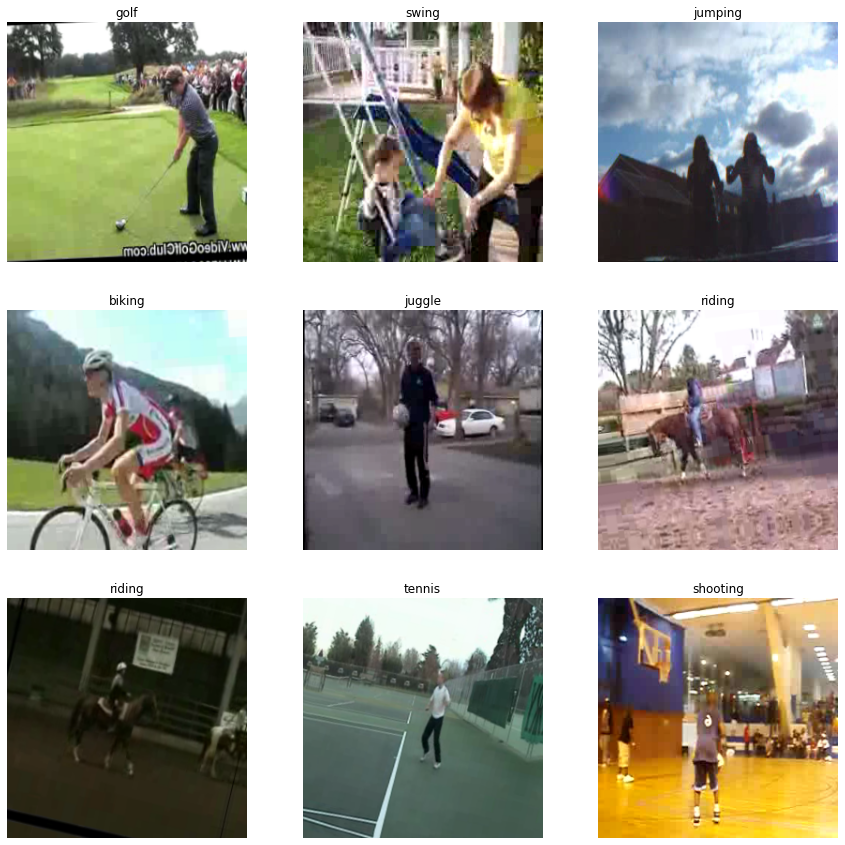

In [25]:
for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X[i])
        plt.title(LABEL_INT_DICT[y[i]])
        plt.axis('off')
    break

In [26]:
# Tensorflow hub를 사용
# https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
# activation : softmax

# optimizer : adam
# loss : sparse_categorical_crossentropy
# metrics : accuracy

In [27]:
# ucf11_weights 디렉토리 생성
# ucf11_weights 안에 학습 데이터를 저장

# 학습
import random

In [28]:
import tensorflow_hub as hub

In [32]:
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2', trainable=True),
    tf.keras.layers.Dense(len(LABEL_INT_DICT), activation='softmax')
])

model.build([None ,256, 256, 3]) # None으로하면 알아서 배치를 채워줌 (batch input shape)

adam = keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer = adam,
    loss = 'sparse_categorical_crossentropy',
    metrics = 'accuracy'
)

In [30]:
import os
os.mkdir('ucf11_weights')

In [33]:
# ucf11_weights 안에 학습 데이터를 저장
filepath = 'ucf11_weights/{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor = 'val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min'
)

history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 50,
    verbose = 1,
    callbacks=[
        model_checkpoint
    ]
)

Epoch 1/50


2022-06-17 22:07:01.902101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2.2166 - accuracy: 0.3032

2022-06-17 22:07:25.941226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.96761, saving model to ucf11_weights/01-0.63.hdf5
18/18 [==============================] - 35s 1s/step - loss: 2.2166 - accuracy: 0.3032 - val_loss: 1.9676 - val_accuracy: 0.6255
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 1.6233 - accuracy: 0.7532
Epoch 2: val_loss improved from 1.96761 to 1.40270, saving model to ucf11_weights/02-0.86.hdf5
18/18 [==============================] - 14s 723ms/step - loss: 1.6233 - accuracy: 0.7532 - val_loss: 1.4027 - val_accuracy: 0.8600
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.0276 - accuracy: 0.8905
Epoch 3: val_loss improved from 1.40270 to 0.85380, saving model to ucf11_weights/03-0.90.hdf5
18/18 [==============================] - 12s 663ms/step - loss: 1.0276 - accuracy: 0.8905 - val_loss: 0.8538 - val_accuracy: 0.8964
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.6162 - accuracy: 0.9236
Epoch 4: val_loss improved from 0.85380 to 

KeyboardInterrupt: 

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='best')
plt.grid()
plt.show()

NameError: name 'history' is not defined

<Figure size 576x432 with 0 Axes>